(gss_vignette)=

# Gaussian stabilizing selection with an optimum shift

This vignette simulates the evolution of a population to a single sudden shift in the optimum trait value.

First, we define a class that will track the mean genetic value and mean fitness of the population over time.
See {ref}`recorders_vignette` for details.

In [1]:
import numpy as np

class Recorder(object):
    def __init__(self, start):
        self.generation = []
        self.gbar = []
        self.wbar = []
        self.start = start    
        
    def __call__(self, pop, sampler):
        if pop.generation > self.start:
            self.generation.append(pop.generation)
            md=np.array(pop.diploid_metadata, copy=False)
            self.gbar.append(md['g'].mean())
            self.wbar.append(md['w'].mean())

Now, we will set up and simulate the model.
We use {class}`fwdpy11.GSSmo` to specify when/how the optimum value shifts.

We will simulate the population for $10N$ generations around an optimum of zero.
Then, we shift the optimum to 1 and evolve another 200 generations.
We set our `Recorder` type defined above to start tracking things after the initial "burn in".

In [2]:
import fwdpy11

pop = fwdpy11.DiploidPopulation(500, 1.0)

rng = fwdpy11.GSLrng(54321)

GSSmo = fwdpy11.GSSmo(
    [
        fwdpy11.Optimum(when=0, optimum=0.0, VS=1.0),
        fwdpy11.Optimum(when=10 * pop.N, optimum=1.0, VS=1.0),
    ]
)

rho = 1000.

p = {
    "nregions": [],
    "gvalue": fwdpy11.Additive(2.0, GSSmo),
    "sregions": [fwdpy11.GaussianS(0, 1., 1, 0.1)],
    "recregions": [fwdpy11.PoissonInterval(0, 1., rho / float(4 * pop.N))],
    "rates": (0.0, 1e-3, None),
    # Keep mutations at frequency 1 in the pop if they affect fitness.
    "prune_selected": False,
    "demography": fwdpy11.DiscreteDemography(),
    "simlen": 10 * pop.N + 200,
}
params = fwdpy11.ModelParams(**p)

r = Recorder(start=10 * pop.N)
fwdpy11.evolvets(rng, pop, params, 100, recorder=r, suppress_table_indexing=True)

Finally, let's plot the results:

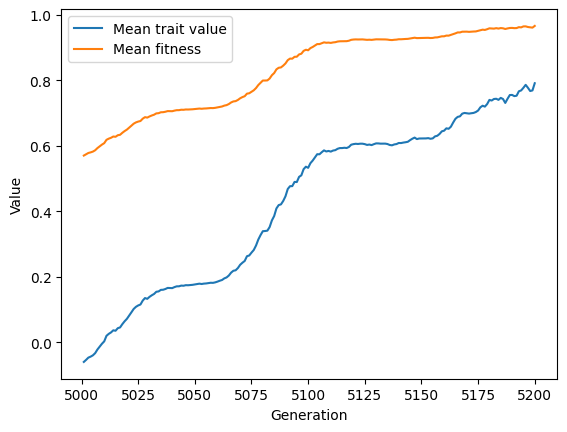

In [3]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot(r.generation, r.gbar, label="Mean trait value")
ax.plot(r.generation, r.wbar, label="Mean fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Value")
plt.legend()
plt.show()